# Red Neuronal Convolucional CIFAR-10

En primer lugar, definiremos todas las clases y funciones que necesitaremos:
Para visualizar el modelo instalar la biblioteca de Keras para investigar arquitecturas y parámetros de modelos secuenciales de Piotr Migdal:

pip install git+git://github.com/stared/keras-sequential-ascii.git

In [1]:
!pip install git+git://github.com/stared/keras-sequential-ascii.git

  Cloning git://github.com/stared/keras-sequential-ascii.git to /tmp/pip-vxu7acut-build
  Running setup.py install for keras-sequential-ascii ... done


In [ ]:
%matplotlib inline
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
# from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")
 
# Importar Tensorflow con multiprocesamiento
import tensorflow as tf
 
# Cargar el conjunto de datos de CIFAR-10
from keras.datasets import cifar10


Como sugiere una buena práctica, debemos declarar nuestras variables:

- tamaño_lote: el número de ejemplos de entrenamiento en la propagación hacia adelante/atrás. Cuanto mayor sea el tamaño del lote, más espacio de memoria necesitará
- num_clases - número de clases del conjuntos de datos cifar-10
- una época - un propagación hacia adelante y una propagación hacia atrás de todos los ejemplos de entrenamiento

In [ ]:
tamaño_lote = 32 
# 32 ejemplos en un mini-lote lotes más pequeños significa más actualizaciones por epoca
 
num_clases = 10 # número de clases de las imágenes
epocas = 20 # repetir 20 veces
data_augmentation = True

Cargar el conjunto de datos CIFAR-10

In [4]:
(x_entrenamiento, y_entrenamiento), (x_prueba, y_prueba) = cifar10.load_data() 
# x_entrenamiento - datos de entrenamiento data(imágenes), y_prueba - etiquetas(digitos)

nombre_clases = ['avion','auto','pajaro','gato','ciervo',
          'perro','rana','caballo','barco','camion']

170500096/170498071 [==============================] - 29s 0us/step


Imprimir figura con 10 imágenes aleatorias del conjunto de datos cifar

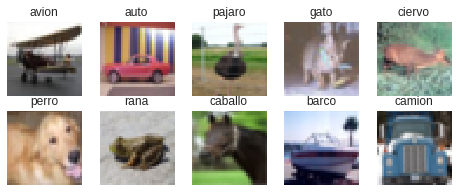

In [5]:
# Imprimir figura con 10 imágenes aleatorias del conjunto de datos cifar

fig = plt.figure(figsize=(8,3))
for i in range(num_clases):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_entrenamiento[:]==i)[0]
    features_idx = x_entrenamiento[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(1,2,0))
    ax.set_title(nombre_clases[i])
    plt.imshow(im)
plt.show()

Los valores de píxel están en el rango de 0 a 255 para cada uno de los canales rojo, verde y azul.

Es una buena práctica trabajar con datos normalizados.

Como los valores de entrada se entienden bien, podemos normalizar fácilmente al rango 0 a 1 dividiendo cada valor por la observación máxima que es 255.

Tenga en cuenta que los datos se cargan como enteros, por lo que debemos convertirlos en valores de coma flotante para realizar la división.

Las variables de salida se definen como un vector de números enteros de 0 a 1 para cada clase.

In [ ]:
# Convertir and y pre-procesar

y_entrenamiento = np_utils.to_categorical(y_entrenamiento, num_clases)
y_prueba = np_utils.to_categorical(y_prueba, num_clases)
x_entrenamiento = x_entrenamiento.astype('float32')
x_prueba = x_prueba.astype('float32')
x_entrenamiento  /= 255
x_prueba /= 255

Comencemos definiendo un modelo simple de CNN de 4 capas convolucionales.

Utilizaremos un modelo con cuatro capas convolucionales seguidas de una combinación máxima y un aplanamiento de la red para capas completamente conectadas para hacer predicciones:

1. Capa de entrada convolucional, 32 filtros con un tamaño de 3 × 3, función de activación ReLU
2. Capa de entrada convolucional, 32 filtros con un tamaño de 3 × 3, una función de activación ReLU
3. Capa de reducción por valor máximo con tamaño 2 × 2
4. Apagado aleatorio "dropout" establecido en 25%
5. Capa de entrada convolucional, 64 filtros con un tamaño de 3 × 3, una función de activación ReLU
6. Capa de entrada convolucional, 64 filtros con un tamaño de 3 × 3, una función de activación ReLU
7. Capa de reducción por valor máximo con tamaño 2 × 2
8. Apagado aleatorio "dropout" establecido en 25%
9. Capa de aplanado
10. Capa completamente conectada con 512 unidades y una función de activación del ReLU
11. Apagado aleatorio "dropout" establecido en 50%
12. Capa de salida completamente conectada con 10 unidades y una función de activación de softmax
 

Entonces podemos ajustar este modelo con 100 épocas y un tamaño de lote de 32.

In [ ]:
def modelo_4():

    modelo = Sequential()
    modelo.add(Conv2D(32, (3, 3), padding='same', input_shape=x_entrenamiento.shape[1:]))
    modelo.add(Activation('relu'))
    modelo.add(Conv2D(32,(3, 3)))
    modelo.add(Activation('relu'))
    modelo.add(MaxPooling2D(pool_size=(2, 2)))
    modelo.add(Dropout(0.25))

    modelo.add(Conv2D(64, (3, 3), padding='same'))
    modelo.add(Activation('relu'))
    modelo.add(Conv2D(64, (3,3)))
    modelo.add(Activation('relu'))
    modelo.add(MaxPooling2D(pool_size=(2, 2)))
    modelo.add(Dropout(0.25))

    modelo.add(Flatten())
    modelo.add(Dense(512))
    modelo.add(Activation('relu'))
    modelo.add(Dropout(0.5))
    modelo.add(Dense(num_clases))
    modelo.add(Activation('softmax'))

    sgd = SGD(lr = 0.01, decay=1e-6, momentum=0.9, nesterov=True)

    # Compilar el modelo

    modelo.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return modelo


Crear el modelo

In [16]:
# Crear el modelo
rnc_4 = modelo_4()
rnc_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 30, 30)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 30, 30)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 15, 15)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 15, 15)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 15, 15)        18496     
__________

Visualizar la estructura del modelo. Para este problema, podemos usar una biblioteca para Keras para investigar arquitecturas y parámetros de modelos secuenciales de Piotr Migdał.https://github.com/stared/keras-sequential-ascii

In [ ]:
# Visualizando la estructura del modelo

sequential_model_to_ascii_printout(rnc_n)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####      3   32   32
              Conv2D    \|/  -------------------       896     0.1%
                relu   #####     32   32   32
              Conv2D    \|/  -------------------      9248     0.7%
                relu   #####     32   30   30
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     32   15   15
             Dropout    | || -------------------         0     0.0%
                       #####     32   15   15
              Conv2D    \|/  -------------------     18496     1.5%
                relu   #####     64   15   15
              Conv2D    \|/  -------------------     36928     3.0%
                relu   #####     64   13   13
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     64    6    6
             Dropout    | || -------------------         0     0.0%
              

Entrenar el modelo

In [20]:
# Entrenar el modelo

rnc4 = rnc_4.fit(x_entrenamiento, y_entrenamiento, batch_size=tamaño_lote, epochs=epocas, validation_data=(x_prueba,y_prueba),shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 26s 527us/step - loss: 0.6946 - acc: 0.7595 - val_loss: 0.6824 - val_acc: 0.7683
Epoch 2/20
17184/50000 [=========>....................] - ETA: 16s - loss: 0.6617 - acc: 0.770950000/50000 [==============================] - 26s 522us/step - loss: 0.6810 - acc: 0.7647 - val_loss: 0.7176 - val_acc: 0.7571
Epoch 3/20
43008/50000 [========================>.....] - ETA: 3s - loss: 0.6774 - acc: 0.764650000/50000 [==============================] - 26s 517us/step - loss: 0.6786 - acc: 0.7649 - val_loss: 0.6746 - val_acc: 0.7666
Epoch 4/20
50000/50000 [==============================] - 26s 513us/step - loss: 0.6711 - acc: 0.7665 - val_loss: 0.6976 - val_acc: 0.7643
Epoch 5/20
 1920/50000 [>.............................] - ETA: 23s - loss: 0.6444 - acc: 0.765150000/50000 [==============================] - 26s 511us/step - loss: 0.6531 - acc: 0.7742 - val_loss: 0.7226 - val_acc: 0.7518
Epoc

### Graficar el proceso de entrenamiento y prueba: costo y exactitud

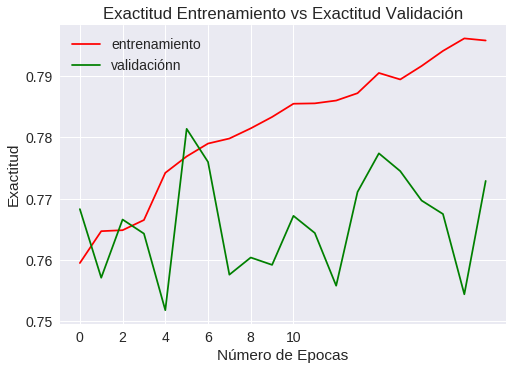

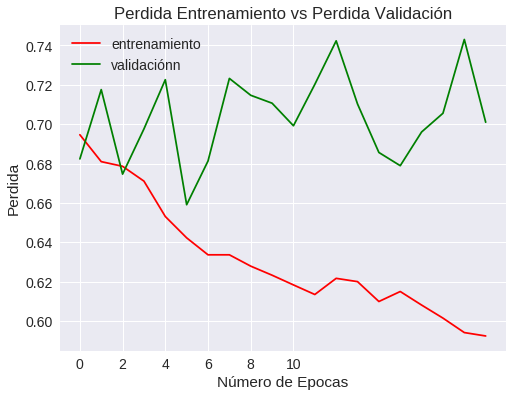

Exactitud: 77.29%


In [21]:
# Graficar el proceso de entrenamiento y prueba: costo y exactitud

plt.figure(0)
plt.plot(rnc4.history['acc'],'r')
plt.plot(rnc4.history['val_acc'],'g')
plt.xticks(np.arange(0, 11, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Número de Epocas")
plt.ylabel("Exactitud")
plt.title("Exactitud Entrenamiento vs Exactitud Validación")
plt.legend(['entrenamiento','validaciónn'])

plt.figure(1)
plt.plot(rnc4.history['loss'],'r')
plt.plot(rnc4.history['val_loss'],'g')
plt.xticks(np.arange(0, 11, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Número de Epocas")
plt.ylabel("Perdida")
plt.title("Perdida Entrenamiento vs Perdida Validación")
plt.legend(['entrenamiento','validaciónn'])
plt.show()

scores = rnc_n.evaluate(x_prueba, y_prueba, verbose=0)
print("Exactitud: %.2f%%" % (scores[1]*100))

### Matriz de Confusión

In [22]:
# Matriz de Confusión

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = rnc_4.predict(x_prueba, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_prueba,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_prueba,axis=1),y_pred)
print(cm)

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000
[[822  11  31  23   8   3  12   8  51  31]
 [ 17 865   3   7   3   4   9   2  20  70]
 [ 70   0 624  56  61  66  79  28  13   3]
 [ 35   3  37 616  45 137  72  44   6   5]
 [ 13   0  42  84 707  21  68  53  11   1]
 [ 17   1  24 169  34 685  24  41   4   1]
 [  8   0  27  50  19  15 870   6   5   0]
 [ 14   1  21  55  36  30  11 822   1   9]
 [ 63  18   4  21   3   4   6   4 851  26]
 [ 20  40   2  21   2   1  11  12  24 867]]


### Vizualizar la Matriz de Confusión

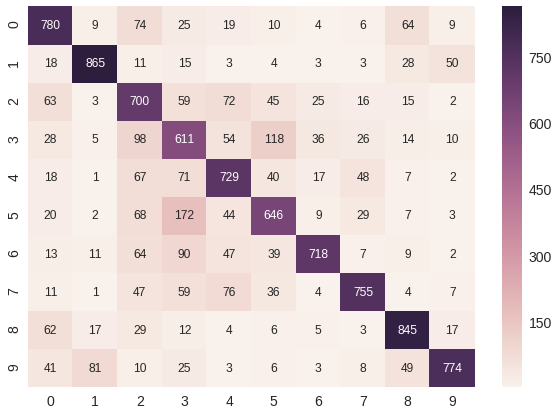

In [36]:
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, fmt='g')# font size
plt.show()

## Red Convolucional de 6 capas

In [ ]:
def modelo_6():
    modelo = Sequential()

    modelo.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_entrenamiento.shape[1:]))
    modelo.add(Dropout(0.2))

    modelo.add(Conv2D(32,(3,3),padding='same', activation='relu'))
    modelo.add(MaxPooling2D(pool_size=(2,2)))

    modelo.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    modelo.add(Dropout(0.2))

    modelo.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    modelo.add(MaxPooling2D(pool_size=(2,2)))

    modelo.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    modelo.add(Dropout(0.2))

    modelo.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    modelo.add(MaxPooling2D(pool_size=(2,2)))

    modelo.add(Flatten())
    modelo.add(Dropout(0.2))
    modelo.add(Dense(1024,activation='relu',kernel_constraint=maxnorm(3)))
    modelo.add(Dropout(0.2))
    modelo.add(Dense(num_clases, activation='softmax'))



    sgd = SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=False)

# Train model

    modelo.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return modelo

Crear Modelo de RNC de 6 capas

In [27]:
# Crear el modelo
rnc_6 = modelo_6()
rnc_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 16, 16)        18496     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 16, 16)        36928     
__________

In [28]:
rnc6 = rnc_6.fit(x_entrenamiento, y_entrenamiento, batch_size=tamaño_lote, epochs=epocas, validation_data=(x_prueba,y_prueba),shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
44704/50000 [=========================>....] - ETA: 4s - loss: 1.8176 - acc: 0.328950000/50000 [==============================] - 44s 870us/step - loss: 1.7842 - acc: 0.3427 - val_loss: 1.6633 - val_acc: 0.4132
Epoch 2/20
35200/50000 [====================>.........] - ETA: 11s - loss: 1.3901 - acc: 0.499750000/50000 [==============================] - 40s 799us/step - loss: 1.3537 - acc: 0.5142 - val_loss: 1.1578 - val_acc: 0.5794
Epoch 3/20
32512/50000 [==================>...........] - ETA: 13s - loss: 1.1517 - acc: 0.586750000/50000 [==============================] - 40s 794us/step - loss: 1.1296 - acc: 0.5945 - val_loss: 0.9774 - val_acc: 0.6553
Epoch 4/20
32800/50000 [==================>...........] - ETA: 12s - loss: 0.9876 - acc: 0.652650000/50000 [==============================] - 39s 783us/step - loss: 0.9741 - acc: 0.6561 - val_loss: 0.9194 - val_acc: 0.6760
Epoch 5/20
32416/50000 [==================>...........] - E

### Graficar el proceso de entrenamiento y prueba: costo y exactitud

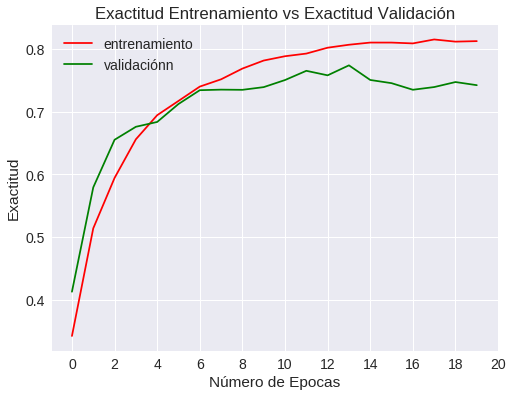

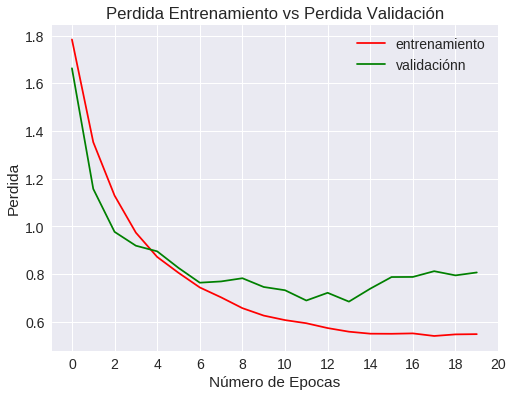

Exactitud: 74.23%


In [32]:
# Graficar el proceso de entrenamiento y prueba: costo y exactitud

plt.figure(2)
plt.plot(rnc6.history['acc'],'r')
plt.plot(rnc6.history['val_acc'],'g')
plt.xticks(np.arange(0, 21, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Número de Epocas")
plt.ylabel("Exactitud")
plt.title("Exactitud Entrenamiento vs Exactitud Validación")
plt.legend(['entrenamiento','validaciónn'])

plt.figure(3)
plt.plot(rnc6.history['loss'],'r')
plt.plot(rnc6.history['val_loss'],'g')
plt.xticks(np.arange(0, 21, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Número de Epocas")
plt.ylabel("Perdida")
plt.title("Perdida Entrenamiento vs Perdida Validación")
plt.legend(['entrenamiento','validaciónn'])
plt.show()

scores = rnc_6.evaluate(x_prueba, y_prueba, verbose=0)
print("Exactitud: %.2f%%" % (scores[1]*100))

### Matriz de Confusión Red Convolucional de 6 capas

In [33]:
# Matriz de Confusión

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = rnc_6.predict(x_prueba, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_prueba,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_prueba,axis=1),y_pred)
print(cm)

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000
[[780   9  74  25  19  10   4   6  64   9]
 [ 18 865  11  15   3   4   3   3  28  50]
 [ 63   3 700  59  72  45  25  16  15   2]
 [ 28   5  98 611  54 118  36  26  14  10]
 [ 18   1  67  71 729  40  17  48   7   2]
 [ 20   2  68 172  44 646   9  29   7   3]
 [ 13  11  64  90  47  39 718   7   9   2]
 [ 11   1  47  59  76  36   4 755   4   7]
 [ 62  17  29  12   4   6   5   3 845  17]
 [ 41  81  10  25   3   6   3   8  49 774]]


### Vizualizar la Matriz de Confusión Red Convolucional de 6 capas

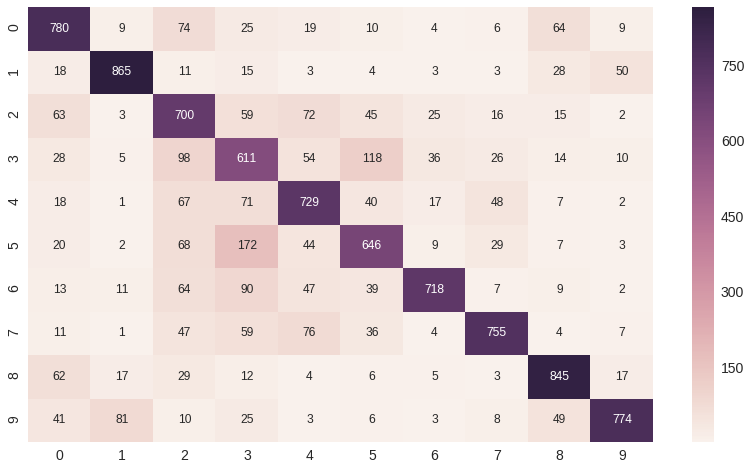

In [35]:
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (14,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, fmt='g')# font size
plt.show()